# Numerical Integration and Differentiation

In [2]:
import timeit

import matplotlib.pyplot as plt
import numpy as np
from ipywidgets import interact, widgets
from matplotlib.patches import Rectangle
from scipy import integrate, optimize

## Integration

In elementary geometry you learned how to calculate the area and volume of simple shapes like circles, cubes, etc..

The topic of this notebook (in contrast to the notebooks on solving ODE's and PDE's, where we will see methods to solve differential equations) is to determine the area under a curve and numerically differentiating curves.


In fact, one of the motivations for the invention of integral calculus was the need to also calculate the area of more complex, irregular shapes.

Methods for approximating the area of such irregular shapes were already known by Archimedes, whose approach was to tile the region with small squares (for which he know the area) and then count the total number of squares.

The principle behind this method is not too far from the currently used methods.

Theoretically, for a function $f:\mathbb{R}\rightarrow\mathbb{R}$ on an interval $[a,b]$, the definition of the integral 

$$I(f)=\int_a^bf(x)\, dx$$

is based on the **Riemann sums** of the form

$$R_n=\sum^n_{i=1}(x_{i+1}-x_i)f(\xi_i)$$

where $a=x_1 <x_2<\cdots<x_n<x_{n+1}=b$ and $\xi_i\in [x_i,x_{i+1}]$, $i=1,\ldots,n$.

Let $h_n=\max\{x_{i+1}-x_i:i=1,\ldots,n-1\}$. If for any choice of $x_i$ such that $h_n\rightarrow 0$ and any choice of $\xi_i$, we have $\lim_{n\rightarrow \infty}R_n=R$, where $R$ is finite, then $f$ is said to be **Riemann integrable** on $[a,b]$, and the value of the integral is $R$.

This method already suggests a method for approximating an integral: just use a finite Riemann sum with $n$ chosen large enough to achieve the desired accuracy. This idea works in principle, but in practice will be far from optimal in comparison to more efficient choices which carefully select $x_i$ and $\xi_i$.

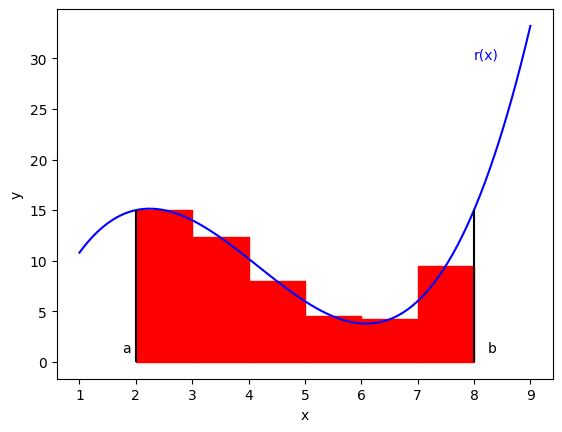

In [3]:
def plot_concept():
    def integrand(x):
        return 1 / 15 * (6 * x - 3) * (x - 5) * (x - 7) + 6

    plt.close("concept")
    fig, ax = plt.subplots(num="concept")
    ts = np.linspace(1, 9, 100)
    ax.plot(ts, integrand(ts), color="Blue")
    ax.vlines(x=2, ymin=0, ymax=integrand(2), color="black")
    ax.vlines(x=8, ymin=0, ymax=integrand(8), color="black")
    rectangles = [
        Rectangle((2, 0), 1, integrand(2.5), color="r"),
        Rectangle((3, 0), 1, integrand(3.5), color="r"),
        Rectangle((4, 0), 1, integrand(4.5), color="r"),
        Rectangle((5, 0), 1, integrand(5.5), color="r"),
        Rectangle((6, 0), 1, integrand(6.5), color="r"),
        Rectangle((7, 0), 1, integrand(7.5), color="r"),
    ]
    for rectangle in rectangles:
        ax.add_patch(rectangle)
    ax.text(1.75, 1, "a")
    ax.text(8.25, 1, "b")
    ax.text(8, 30, "r(x)", color="Blue")
    ax.set_xlabel("x")
    ax.set_ylabel("y")


plot_concept()

## Existence, Uniqueness, Conditioning

- For all practical purposes, a function is integrable if it is bounded (no singularities) with at most a finite number of points of discontinuity within the interval of integration. 

- Since all the Riemann sums defining the Riemann integral of a given function on a given interval must have the same limit, uniqueness of the Riemann integral is built into its definition.

- The conditioning of an integration problem is a measure of the sensitivity to perturbations in the input data. Because integration is an averaging or smoothing process that tends to dampen the effect of small changes in the integrand, integration problems are typically well-behaved with a small condition number.

## Numerical Quadrature

### Introduction

In your calculus course you learned to evaluate a definite integral

$$I(f)=\int_b^af(x)\,dx$$

analytically by finding an **antiderivative** $F$ of the integrand function $f$, where 

$$I(f)=F(b)-F(a).$$

Unfortunately, for some integrals such a closed form does not exist (e.g. $f(x)=\exp(-x^2)$), or they are too complicated to evaluate.
In these cases, you can use numerical methods to approximate the value of these integrals. 

The numerical approximation of definite integrals is called **numerical quadrature**. 
This name derives from the ancient methods for approximating areas of irregular shapes by tiling them by small squares, as mentioned above.

To achieve this, we will build upon the definition of Riemann sums: the integral will be approximated by a weighted sum of integrand values at a finite number of sample points in the interval of integration.
Specifically, the integral $I(f)$ is approximated by an $n$-point **quadrature rule**, which has the form

$$Q_n(f)=\sum_{i=1}^n w_i f(x_i),$$

where $a\leq x_1 < x_2 <\ldots< x_{n}\leq b$.

The points $x_i$ at which the integrand $f$ is evaluated are called **nodes** or **abscissas**, and the multipliers $w_i$ are called **weights** or **coefficients**. A quadrature rule is said to be **open** if $a<x_1$ and $x_n<b$, and  **closed** if $a=x_1$ and $b=x_n$. 

In the next subsections, we will have a look at several methods to choose the nodes and weights with the goal to obtain the best accuracy at the lowest computational cost.

Quadrature rules can be derived using polynomial interpolation. 
Effectively, 
- The integrand function $f$ is evaluated at the points $x_i$, $i = 1,\ldots, n$.
- The polynomial of degree $n − 1$ that interpolates the function values at those points is determined.
- The integral of the interpolant is then taken as an approximation to the integral of the original function.

To find the weights corresponding to a quadrature rule that integrates the first $n$ polynomial basis functions exactly, we can use the **method of undetermined coefficients**.

If we use the monomial basis, e.g. this strategy results in the following **system of moment equations** with $n$ equations in $n$ unknowns.

#### General system of moment equations

$$
\begin{aligned}
w_1\cdot 1 +w_2\cdot 1 +\cdots+w_n\cdot 1 &= \int_a^b 1\, dx = b-a \\
w_1\cdot x_1 +w_2\cdot x_2 +\cdots+w_n\cdot x_n &= \int_a^b x\, dx = (b^2-a^2)/2 \\
\vdots \\
w_1\cdot x_1^{n-1} +w_2\cdot x_2^{n-1} +\cdots+w_n\cdot x_n^{n-1} &= \int_a^b x^{n-1}\, dx = (b^n-a^n)/n
\end{aligned}
$$

In matrix form this becomes:

$$
\begin{bmatrix}
1&1&\cdots&1\\
x_1&x_2&\cdots&x_n\\
\vdots&\vdots&\ddots&\vdots\\
x_1^{n-1}&x_2^{n-1}&\cdots&x_n^{n-1}\end{bmatrix}
\begin{bmatrix}w_1\\w_2\\\vdots\\w_n\end{bmatrix}=
\begin{bmatrix}b-a\\(b^2-a^2)/2\\\vdots\\(b^n-a^n)/n\end{bmatrix}
$$

> **Example**
>
> As an example we use the method of undetermined coefficients to derive a three-point quadrature rule
>
> $$Q_3(f)=w_1f(x_1)+w_2f(x_2)+w_3f(x_3)$$
>
> for the interval $[a,b]$ using the monomial basis. 
> We take the two endpoints and the midpoint as the nodes:
> - $x_1=a$
> - $x_2=(a+b)/2$
> - $x_3=b$
>
> This results in the following linear system:
>
> $$\begin{bmatrix}
1&1&1 \\
a&(a+b)/2&b \\
a^2&((a+b)/2)^2&b^2\end{bmatrix}
\begin{bmatrix}w_1\\w_2\\w_3\end{bmatrix}=
\begin{bmatrix}b-a\\(b^2-a^2)/2\\(b^3-a^3)/3\end{bmatrix}
$$
>
> Solving this system, we find the weights:
> - $w_1 = (b-a)/6$
> - $w_2 = 2(b-a)/3$
> - $w_3 = (b-a)/6$
>
> The resulting quadrature rule is known as **Simpson's rule** and is an example of a Newton-Cotes quadrature rule.

#### Accuracy and useful concepts

By construction, an $n$-point interpolatory quadrature rule integrates each of the first $n$ monomial basis functions exactly, and hence by linearity it integrates any polynomial of degree at most $n-1$ exactly.
A quadrature rule is said to be of **degree** $d$ if it is exact (i.e., the error is zero) for every polynomial of degree $d$ but is not exact for some polynomial of degree $d + 1$.
An $n$-point interpolatory quadrature rule is of degree at least $n-1$.


The significance of the degree is that it conveniently characterizes the **accuracy** of a given rule. 
If $Q_n$ is an interpolatory quadrature rule, and $p_{n−1}$ is the polynomial of degree at most $n-1$  interpolating a sufficiently smooth integrand $f$ at the nodes $x_1,\cdots,x_n$, then we get the following rough error bound for the approximate integral:

$$\|I(f)-Q_n(f)\|\leq\frac{1}{4}h^{n+1}\|f^{(n)}\|_\infty$$ 

where $h = \max\{x_{i+1} - x_i : i = 1,\ldots, n-1\}$.

the preceding general bound already indicates that we can obtain higher accuracy by taking $n$ larger, or $h$ smaller, or both.

- When the number of sample points is increased, say from $n$ to $m$, an important factor affecting efficiency is whether the $n$ function values already computed can be reused in the new rule, so that only $m-n$ new function values need be computed.
A sequence of quadrature rules is said to be **progressive** if the nodes of $Q_{n1}$ are a subset of those of $Q_{n2}$ for $n_2 > n_1$ .

- Instead of (or in addition to) increasing the number of points (and hence the degree), the preceding bound also suggests that the error can be reduced by subdividing the interval of integration into smaller subintervals and applying the quadrature rule separately in each, since this will reduce $h$.
This approach, which is equivalent to using piecewise polynomial interpolation on the original interval, leads to **composite (or compound) quadrature rules**, which we will consider below.
For now, we will focus on **simple quadrature rules**, in which a single rule is applied over the entire given interval.

### Newton-Cotes  Quadrature

#### Definition and common cases

The simplest placement of nodes for an interpolatory quadrature rule is to choose equally spaced points in the interval $[a, b]$, which is the defining property of **Newton-Cotes quadrature**.
An $n$-point **open Newton-Cotes rule** excludes the edges and has nodes:

$$x_i = a + i (b − a)/(n + 1)\quad,\quad  i = 1,\cdots, n.$$

An $n$-point **closed Newton-Cotes rule** includes the edges and has nodes:

$$x_i = a + (i − 1) (b − a)/(n − 1)\quad,\quad i = 1,\cdots, n.$$

The simplest and best known examples are:

- **The midpoint rule**.
  Interpolating the function value at the midpoint of the interval by  a polynomial of degree zero (i.e., a constant) gives the one-point   open Newton-Cotes rule known as **the midpoint rule**:

    $$M(f)=(b-a)f\left(\frac{a+b}{2}\right)$$

- **The trapezoid rule**
  Interpolating the function values at the two endpoints of the interval by a polynomial of degree one (i.e., a straight line) gives the two-point closed Newton-Cotes rule known as **the trapezoid rule**:

    $$T(f)=\frac{b-a}{2}(f(a)+f(b))$$

- **Simpson's rule**
  Interpolating the function values at the two endpoints and the midpoint by a polynomial of degree two (i.e., a quadratic) gives the three-point closed Newton-Cotes rule known as **Simpson’s rule**:

    $$S(f)=\frac{b-a}{6}\left(f(a)+4 f\left(\frac{a+b}{2}\right)+f(b)\right)$$

> **Example**
> 
> To illustrate the application of Newton-Cotes quadrature rules, we approximate the integral
>
> $$I(f)=\int_0^1e^{-x^2}\,dx$$
>
> using each of the three Newton-Cotes quadrature rules just given.
> 
> $$
\begin{aligned}
M(f) &= (1-0)\exp(-0.25)\approx 0.778801 \\
T(f) &= \frac{1}{2}(\exp(0) + \exp(−1))\approx 0.683940 \\
S(f) &= \frac{1}{6}\left(\exp(0) + 4 \exp(−0.25) + \exp(−1)\right)\approx0.747180
\end{aligned}
$$
>
> The correctly rounded result for this problem is 0.746824. 
>
> It is somewhat surprising to see that: 
> - the magnitude of the error from the trapezoid rule (0.062884) is about twice that from the midpoint rule (0.031977), 
> - and that Simpson’s rule, with an error of only 0.000356, seems remarkably accurate considering the size of the interval over which it is applied.

#### Error Analysis

The errors of the three Newton-Cotes rules can be analyzed with a Taylor series expansion of the integrand $f$ about the midpoint $m = (a + b)/2$ of the interval $[a, b]$:

$$f(x)=f(m)+f'(m)(x-m)+\frac{f''(m)}{2}(x-m)^2+\frac{f'''(m)}{6}(x-m)^3+\frac{f^{(4)}(m)}{24}(x-m)^4+\cdots$$

Integrating this Taylor series from $a$ to $b$ leads to an exact expression for the integral, when all terms are included.
Note that the odd-order terms drop out, yielding:

$$
\begin{aligned}
  I(f) &= f(m) (b-a)+ \frac{f''(m)}{24}(b-a)^3+\frac{f^{(4)}(m)}{1920}(b-a)^5+\cdots \\
  &=M(f)+E(f)+F(f)+\cdots
\end{aligned}
$$

where $M(f)$, $E(f)$ and $F(f)$ represent the first three terms in the exact expression for the integral.
Below, we will write the three Newton-Cotes rules in terms of the Taylor series and compare the outcome to the exact answer.
This will reveal the errors of those rules, broken down in different contributions of the form $c_p(b-a)^p$, where $p$ is always an odd power and $c_p$ is a linear coefficient.

- **Midpoint rule**

  The midpoint rule simply coincides with the first term of $I(f)$, namely $M(f)$, meaning that the leading-order term of the error is $E(f)$.
  Hence, the error is proportional to the width of the interval cubed.

- **Trapezoid rule**

  To derive a comparable error expansion for the trapezoid quadrature rule, evaluate the Taylor series twice, once for $x = a$ and once for $x = b$.
  Substitute these results into the rule $\frac{f(b)+f(a)}{2}(b - a)$.
  Then, observe once again that the odd-order terms drop out, and rewrite the leading terms as a function of $M(f)$, $E(f)$ and $F(f)$.
  This will result in:

    $$T(f) = M(f) + 3E(f) + 5F(f) + \cdots$$

    We may now compute the difference with the exact solution:

    $$T(f) - I(f) = 2E(f) + 4F(f) + \cdots$$

    We may also compute other differences:

    $$T(f) - M(f) = 3E(f) + 5F(f) + \cdots$$

    and hence the difference between the two quadrature rules provides an estimate for the dominant term in their error expansions

    $$E(f)\approx\frac{T(f)-M(f)}{3}$$

    provided that the length of the interval is sufficiently small that $(b-a)^5 \ll (b-a)^3$, and the integrand $f$ is such that $f^{(4)}$ is well-behaved. 

    Under these assumptions, we may draw several conclusions from the preceding derivations

  1. The midpoint rule is about twice as accurate as the trapezoid rule, despite being based on a polynomial interpolant of degree one less.

  2. The difference between the midpoint rule and the trapezoid rule can be used to estimate the error in either of them.

  3. Halving the length of the interval decreases the error in either rule by a factor of about $1/8$.


- **Simpson's rule**

  An appropriately weighted combination of the midpoint and trapezoid rules eliminates the leading term, $E(f)$, from the error expansion:

    $$S(f) = \frac{2}{3}M(f) + \frac{1}{3}T(f) = M(f) + E(f) + \frac{5}{3}T(f) + \ldots$$

    with error

    $$S(f) - I(f)=\frac{2}{3}F(f)+\cdots$$

    which provides an alternative derivation for Simpson’s rule as well as an expression for its dominant error term.

In general, for any odd value of $n$, an $n$-point Newton-Cotes rule has degree one greater than that of the polynomial interpolant on which it is based due to cancellation of positive and negative errors.

This implies that the midpoint rule integrates linear polynomials exactly, and hence its degree is one rather than zero. Similarly, the error for Simpson’s rule depends on the fourth and higher derivatives in the Taylor expansion, which vanish for cubic as well as quadratic polynomials, so that Simpson’s rule is of degree three rather than two (which explains the surprisingly high accuracy obtained in the previous example).


> **Example**
>
> We illustrate these error estimates by computing the approximate value for the integral
>
> $$\int_0^1 x^2\,dx$$
>
> Using the midpoint rule, we obtain
>
> $$M(f)= (1-0)\left(\frac{1}{2}\right)^2=\frac{1}{4}$$
>
> and using the trapezoid rule we obtain
>
> $$T(f)=\frac{1-0}{2}(0^2+1^2)=1/2$$
>
> Thus, we have the error estimate
>
> $$E(f)\approx\frac{T(f)-M(f)}{3}=\frac{1/4}{3}=\frac{1}{12}$$
>
> We conclude that the error in $M(f)$ is about $1/12$ and the error in $T(f)$ is about $-1/6$.
> In addition, we can now compute the approximate value given by Simpson’s rule for this integral,
>
> $$S(f)=\frac{2}{3}M(f)+\frac{1}{3}T(f)=\frac{2}{3}\cdot\frac{1}{4}+\frac{1}{3}\cdot\frac{1}{2}=\frac{1}{3}$$
>
> which is exact for this integral (as is to be expected since, by design, Simpson’s rule is exact for quadratic polynomials). 
> Thus, the error estimates for $M(f)$ and $T(f)$ are exact for this integrand (though this would not be true in general).

#### Closing remarks

Newton-Cotes quadrature rules are relatively easy to derive and to apply, but they have some serious drawbacks. 
The interpolation of a continuous function at equally spaced points by a high-degree polynomial may suffer from unwanted oscillation, and as the number of interpolation points grows, convergence to the underlying function is not guaranteed.

it can be shown that every n-point Newton-Cotes rule with $n \geq 11$ has at least one negative weight and that the sum of all weights tends to infinity as $n\rightarrow \infty$.

This means that Newton-Cotes rules become arbitrarily ill-conditioned, and hence unstable, as the number of points grows.
The presence of large positive and negative weights also means that the value of the integral is computed as a sum of large quantities of differing sign, and hence substantial cancellation is likely in finite-precision arithmetic.

For these reasons, we cannot expect to attain arbitrarily high accuracy on a given interval by using a Newton-Cotes rule with a large number of points. 
In practice, therefore, Newton-Cotes rules are usually restricted to a modest number of points, and if higher accuracy is required, then the interval is subdivided and the rule is applied in each subinterval separately (as we'll see below).

#### Example integrand

Throughout this notebook, integration algorithms are often tested with the same test case:

$$I = \int_0^1 \exp(-x^2)\,dx$$

The function and the full double precision answer are defined in the following cell:

In [4]:
def func(x):
    return np.exp(-(x**2))


EXACT = 0.746824132812427

#### DIY `scipy` integration

The [`integrate.newton_cotes`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.integrate.newton_cotes.html) function returns the weights and error coefficient for Newton-Cotes integration with $n$ equally spaced data points. 

It can therefore be used to compute the integral of a function, using as many points as you wish to evaluate it.

Order  Quadrature Result  Error
----------------------------------------
1      0.683939721        6.28844e-02
2      0.747180429        3.56296e-04
3      0.746992320        1.68187e-04
4      0.746833710        9.57704e-06
5      0.746829357        5.22439e-06
6      0.746823757        3.76241e-07
7      0.746823905        2.27545e-07
8      0.746824142        9.02894e-09
9      0.746824139        5.73098e-09
10     0.746824133        1.71191e-10
11     0.746824133        1.11842e-10
12     0.746824133        2.73914e-12
13     0.746824133        1.82465e-12
14     0.746824133        3.81917e-14
15     0.746824133        3.13594e-12
16     0.746824133        7.56706e-12
17     0.746824133        9.09339e-12
18     0.746824133        1.21812e-10
19     0.746824133        7.16401e-11
20     0.746824132        1.10986e-09
21     0.746824133        1.90609e-10
22     0.746824131        2.02248e-09
23     0.746824138        5.62692e-09
24     0.746824197        6.39478e-08
25     0.746824

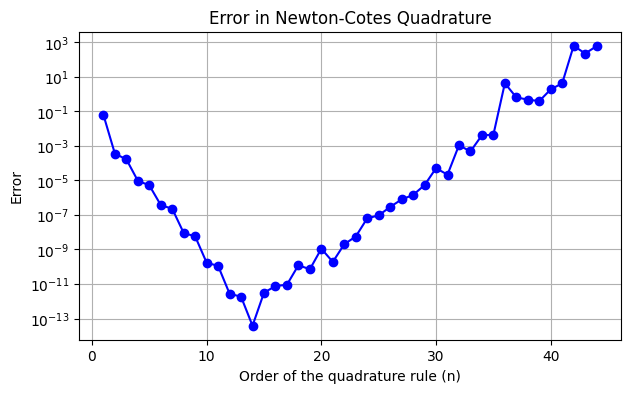

In [5]:
def demo_newton_cotes(rn):
    a = 0
    b = 1
    x = np.linspace(a, b, rn + 1)
    an, _B = integrate.newton_cotes(rn, 1)
    dx = (b - a) / rn
    quad = dx * np.sum(an * func(x))
    error = abs(quad - EXACT)
    return quad, error


def demo_newton_cotes_weakness():
    rns = np.arange(1, 45)
    errors = []

    print(f"{'Order':<6} {'Quadrature Result':<18} {'Error'}")
    print("-" * 40)

    for rn in rns:
        quad, error = demo_newton_cotes(rn)
        print(f"{rn:<6} {quad:<18.9f} {error:.5e}")
        errors.append(error)

    # Plotting the error as a function of quadrature order
    plt.close("newton_cotes_weakness")
    fig, ax = plt.subplots(figsize=(7, 4), num="newton_cotes_weakness")
    ax.plot(rns, errors, marker="o", linestyle="-", color="blue")
    ax.set_xlabel("Order of the quadrature rule (n)")
    ax.set_ylabel("Error")
    ax.set_title("Error in Newton-Cotes Quadrature")
    ax.set_yscale("log")
    ax.grid(True)


demo_newton_cotes_weakness()

This graph effectively shows that more data points does not always mean better results.
The optimal number of data points is in this example about 15, because this produces the smallest error.
When we look at the value that corresponds with 15 data points, this is also an accurate approximation of the exact value.
10 to 20 data points also approximate these values well, but as soon as the number of data points exceeds 35, the error becomes very large, very quickly.

### Clenshaw-Curtis Quadrature

We saw in the *interpolation* notebook that the Chebyshev points have distinct advantages over equally spaced points for interpolating a continuous function by a polynomial. 
Similarly, when choosing the nodes in a quadrature rule based on the Chebysev points, we also improve upon the Newton-Cotes rules.

With the Chebyshev points as nodes for a given $n$, the corresponding weights can again be calculated using the method of undetermined coefficients. 
It can be shown that the resulting weights are always positive for any $n$, and that the resulting approximate
values converge to the exact integral as $n \rightarrow \infty$.
Thus, quadrature rules based on the Chebyshev points are extremely attractive in that they are always stable and
significantly more accurate than Newton-Cotes rules for the same number of nodes.

Additionally, this type of quadrature rule can be implemented using techniques based on the fast Fourier transform. 
These efficient implementations of quadrature rules based on the Chebyshev points have become
known as **Clenshaw-Curtis quadrature**.

We have seen that Clenshaw-Curtis quadrature rules have many virtues: stability, accuracy, simplicity and progressiveness.
Nevertheless, the degree of an $n$-point rule is only $n − 1$, which is well below the maximum possible. 
Next, we will see that quadrature rules of maximum degree can be derived by exploiting all of the available degrees of freedom.

In [1]:
import numpy as np

def clenshaw_curtis_weights(N):
    """
    Clenshaw–Curtis nodes x_j = cos(j*pi/N), j=0..N, on [-1,1]
    and corresponding weights w_j such that integral_{-1}^1 f(x) dx ≈ sum w_j f(x_j).
    Based on the classic Trefethen 'clencurt' formula.
    """
    if N == 0:
        return np.array([0.0]), np.array([2.0])

    theta = np.pi * np.arange(N + 1) / N
    x = np.cos(theta)

    w = np.zeros(N + 1)
    ii = np.arange(1, N)  # interior indices 1..N-1
    v = np.ones(N - 1)

    if N % 2 == 0:
        # N even
        w[0] = 1.0 / (N**2 - 1.0)
        w[-1] = w[0]
        for k in range(1, N//2):
            v -= 2.0 * np.cos(2*k*theta[ii]) / (4*k**2 - 1.0)
        v -= np.cos(N*theta[ii]) / (N**2 - 1.0)
    else:
        # N odd
        w[0] = 1.0 / (N**2)
        w[-1] = w[0]
        for k in range(1, (N+1)//2):
            v -= 2.0 * np.cos(2*k*theta[ii]) / (4*k**2 - 1.0)

    w[ii] = 2.0 * v / N
    return x, w


def clenshaw_curtis_integrate(f, a, b, N):
    # nodes/weights on [-1,1]
    x, w = clenshaw_curtis_weights(N)

    # affine map to [a,b]
    xm = 0.5*(a + b) + 0.5*(b - a)*x
    wm = 0.5*(b - a)*w

    return np.sum(wm * f(xm))


# ---- demo: ∫_0^1 e^x dx = e - 1 ----
f = np.exp
exact = np.e - 1.0

for N in [2, 4, 8, 16, 32, 64]:
    approx = clenshaw_curtis_integrate(f, 0.0, 1.0, N)
    err = abs(approx - exact)
    print(f"N={N:2d}  approx={approx:.16f}  error={err:.3e}")


N= 2  approx=1.7188611518765931  error=5.793e-04
N= 4  approx=1.7182814859233657  error=3.425e-07
N= 8  approx=1.7182818284590291  error=1.599e-14
N=16  approx=1.7182818284590453  error=2.220e-16
N=32  approx=1.7182818284590453  error=2.220e-16
N=64  approx=1.7182818284590455  error=4.441e-16


### Gaussian Quadrature

In all the preceding quadrature rules we chose the $n$ nodes ourselves and then determined the $n$ corresponding weights to maximize the degree of the resulting quadrature rule. 
With only n parameters free to be chosen, the resulting degree is generally $n − 1$.

If the locations of the nodes were also freely chosen, however, then there would be $2n$ free parameters, so that a degree of $2n − 1$ should be achievable. 
In Gaussian quadrature, both the nodes and the weights are optimally chosen to maximize the degree of the resulting quadrature rule.

In general, for each $n$ there is a unique $n$-point Gaussian rule, and it is of degree $2n − 1$.
Gaussian quadrature rules therefore have the highest possible accuracy for the number of nodes used, but they are significantly more difficult to derive than Newton-Cotes rules. 

The nodes and weights can still be determined by the method of undetermined coefficients, but the resulting system of equations is nonlinear.

> **Example**
>
> We will derive a two-point Gaussian quadrature rule on the interval $[−1, 1]$,
>
> $$I(f)=\int_{-1}^1f(x)dx\approx w_1f(x_1)+w_2f(x_2)=G_2(f)$$
> 
> where we can still freely choose $w_1,w_2$ and $x_1$ and $x_2$
>
> The requirement that the first four monomials need to be integrated exactly gives rise to the following equations
>
> $$
\begin{aligned}
w_1+w_2 &= \int_{-1}^1 1\,dx=2 \\
w_1x_1+w_2x_2 &= \int_{-1}^1 x\,dx=0 \\
w_1x_1^2+w_2x_2^2 &= \int_{-1}^1 x^2\,dx=2/3 \\
w_1x_1^3+w_2x_2^3 &= \int_{-1}^1 x^3\,dx=0
\end{aligned}
$$
>
> Let's solve this nonlinear system using `scipy`


In [6]:
def gauss_2point_a_eqs(x):
    """The multidimensional function containing the 4 equations above.

    - `x[0]` and `x[1]` represent $w_1$ and $w_2$.
    - `x[2]` and `x[3]` represent $x_1$ and $x_2$.
    """
    return [
        x[0] + x[1] - 2,
        x[0] * x[2] + x[1] * x[3],
        x[0] * x[2] ** 2.0 + x[1] * x[3] ** 2.0 - 2.0 / 3.0,
        x[0] * x[2] ** 3.0 + x[1] * x[3] ** 3.0,
    ]


# Solve this system with initial guess [1, 1, 1, 1].
optimize.root(gauss_2point_a_eqs, [1, 1, 1, 1]).x

array([1., 1., 1., 1.])

> As shown above, one solution for this system is given by
>
> - $x_1=-1/\sqrt{3}\approx-0.57735027$
> - $x_2=1/\sqrt{3}\approx0.57735027$
> - $w_1=1$
> - $w_2=1$
>
> Thus the two-point Gaussian quadrature rule has the form
>
> $$G_2(f)=f(-1/\sqrt{3})+f(1/\sqrt{3})$$
>
> and by construction it has degree three.


Another example on how Gaussion Quadrature works, but now for the interval $[2, 8]$ and plotted for the integrand $f(x) = \frac{1}{15}(6x-3)(x-5)(x-7)+3$

[ 5.81289175  5.8970391  -6.20816465 10.91915352]


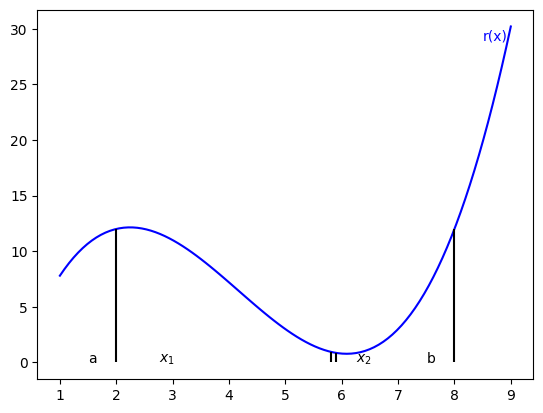

In [7]:
def gauss_2point_b_eqs(x):
    return [
        x[2] + x[3] - 6,
        x[2] * x[0] + x[3] * x[1] - 30,
        x[2] * x[0] ** 2 + x[3] * x[1] ** 2 - 168,
        x[2] * x[0] ** 3 + x[3] * x[1] ** 3 - 1020,
    ]


def example_gc28():
    def integrand(x):
        return 1 / 15 * (6 * x - 3) * (x - 5) * (x - 7) + 3

    solution = optimize.root(gauss_2point_b_eqs, [2, 2, 1, 1]).x
    print(solution)
    ts = np.linspace(1, 9, 100)
    plt.close("gc28")
    fix, ax = plt.subplots(num="gc28")
    ax.plot(ts, integrand(ts), color="Blue")
    ax.vlines(x=2, ymin=0, ymax=integrand(2), color="black")
    ax.vlines(x=8, ymin=0, ymax=integrand(8), color="black")
    ax.vlines(x=solution[0], ymin=0, ymax=integrand(solution[0]), color="black")
    ax.vlines(x=solution[1], ymin=0, ymax=integrand(solution[1]), color="black")
    ax.text(1.5, 0, "a")
    ax.text(7.5, 0, "b")
    ax.text(2.75, 0, "$x_1$")
    ax.text(6.25, 0, "$x_2$")
    ax.text(8.5, 29, "r(x)", color="Blue")


example_gc28()

#### Properties

- These examples are typical in that for any $n$ the Gaussian **nodes are symmetrically** placed about the midpoint of the interval; for odd values of $n$ the midpoint itself is always a node.

- This example is also typical in that the **nodes are usually irrational numbers**, even if the endpoints a and b are rational. 
This feature makes Gaussian rules relatively inconvenient to calculate by hand, compared to simple Newton-Cotes rules.
Usually, tabulated values are used for Gaussian quadrature.

- Gaussian quadrature rules are also harder to apply than Newton-Cotes rules because the weights and nodes are derived for some specific interval and thus any other interval of integration must be transformed into
the standard interval for which the nodes and weights have been tabulated.

If we want to use a quadrature rule that is tabulated on the interval $[\alpha,\beta]$,

$$\int_\alpha^\beta f(x)dx\approx\sum_{i=1}^n w_if(x_i)$$

to approximate an integral on the interval $[a, b]$,

$$I(g)=\int_a^b g(t)\, dt$$

then we must use a change of variable from $x$ in $[\alpha, \beta]$ to $t$ in $[a, b]$.
Many such transformations are possible, but a simple linear transformation

$$t=\frac{(b-a)x+a\beta-b\alpha}{\beta-\alpha}$$

has the advantage of preserving the degree of the quadrature rule.
The integral is then given by 

$$I(g)\approx \frac{b-a}{\beta-\alpha}\sum^n_{i=1}w_i g\left(\frac{(b-a)x_i+a\beta-b\alpha}{\beta-\alpha}\right)$$

> **Example**
>
> To illustrate a change of interval, we use the two-point Gaussian quadrature rule G_2 derived for the interval $[−1, 1]$ in the previous example to approximate the integral
>
> $$I(g)=\int^1_0e^{-t^2}\,dt$$
>
> Using the linear transformation of variable just shown, we have
>
> $$ t=\frac{x+1}{2}$$
>
> so that the integral is approximated by $G_2(g)$=
>
> $$\frac{1}{2}\left[\exp\left(-\left(\frac{(-1/\sqrt{3})+1}{2}\right)^2\right)+ \exp\left(-\left(\frac{(1/\sqrt{3})+1}{2}\right)^2\right)\right]\approx0.746595$$
>
> which is slightly more accurate than the result given by Simpson's rule for this integral, despite using only two points instead of three.

This algorithm is implemented in [`integrate.fixed_quad`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.integrate.fixed_quad.html#scipy.integrate.fixed_quad) which "Integrate func from a to b using Gaussian quadrature of order n."

In [8]:
def demo_quadrature():
    """Illustrate `integrate.quadrature` with the integral int_0^1 exp(-x**2) dx."""
    y, _ = integrate.fixed_quad(func, 0, 1, n=2)
    print(f"integral = {y:.10f}")


demo_quadrature()

integral = 0.7465946883


In the figure above you see an example of a lineair transformation of the variable. This is needed because if you work with variable t, the integral has boundaries 0 and 1, this is not tabulated for Gaussian quadrature. When you work with variable x, the boundaries are given by -1 and 1, these values are tabulated for Gaussian quadrature and hence are simple to work with.

By design, Gaussian quadrature rules have maximal degree, and hence optimal accuracy, for the number of points used. 
Moreover, it can be shown that the resulting weights are always positive for any $n$, so that Gaussian quadrature rules are always stable and the resulting approximate values converge to the exact integral as $n \rightarrow \infty$.


Unfortunately, Gaussian quadrature rules also have a serious drawback:

> for $m \neq n$, $G_m$ and $G_n$ have no nodes in common (except for the midpoint when $m$ and $n$ are both odd).
> Thus, Gaussian rules are **not progressive**, which means that when the number of nodes is increased, say from $n$ to $m$, $m$ new evaluations of the integrand are required rather than $m − n$. 

Avoiding this additional work is the motivation for **Kronrod quadrature rules**.
Such rules come in pairs: an $n$-point Gaussian rule $G_n$ and a $(2n+1)$-point Kronrod rule $K_{2n+1}$ whose nodes are optimally chosen subject to the constraint that all of the nodes of $G_n$ are reused in $K_{2n+1}$.
Thus, $n$ of the nodes used in $K_{2n+1}$ are prespecified, leaving the remaining $n + 1$ nodes, as well as all $2n + 1$ of the weights (including those corresponding to the nodes of $G_n$ ), free to be chosen to maximize the degree of the resulting rule.
The rule $K_{2n+1}$ is therefore of degree $3n + 1$, whereas a true $(2n + 1)$-point Gaussian rule would be of degree $4n + 1$.
Thus, there is a tradeoff between accuracy and efficiency.

One of the main reasons for using two quadrature rules with different numbers of points is to obtain an error estimate for the approximate value of the integral based on the difference between the values given by the two rules.
In using a Gauss-Kronrod pair, the value of $K_{2n+1}$ is taken as the approximation to the integral, and a realistic but conservative estimate for the error, based partly on theory and partly on experience, is given by

$$(200\|G_n-K_{2n+1}\|)^{1.5}$$

Because they efficiently provide both high accuracy and a reliable error estimate, Gauss-Kronrod rules are among the most effective quadrature methods available, and they form the basis for many of the quadrature routines in major software libraries. 
The pair of rules ($G_7$ , $K_{15}$ ), in particular, has become a commonly used standard

### Composite Quadrature

Thus far we have considered simple quadrature rules obtained by interpolating the integrand function by a single polynomial over the entire interval of integration. 

The accuracy of such a rule can be increased, and the error estimated, by increasing the number of interpolation points, and hence the corresponding degree of the polynomial interpolant. 

An alternative is to subdivide the original interval into two or more subintervals and apply a simple quadrature rule in each subinterval.
Summing these partial results then yields an approximation to the overall integral.

Such an approach is equivalent to using piecewise polynomial interpolation on the original interval and then integrating the piecewise interpolant to approximate the integral.

A **composite**, or **compound**, quadrature rule on a given interval $[a, b]$ results from subdividing the interval into $k$ subintervals, typically of uniform length $h = (b − a)/k$, applying an $n$-point simple quadrature rule $Q_n$ in each subinterval, and then taking the sum of these results as the approximate value of the integral.

If the rule $Q_n$ is open, then evaluating the composite rule will require $kn$ evaluations of the integrand function. 
If $Q_n$ is closed, on the other hand, then some of the points are repeated, so that only $k(n − 1) + 1$ evaluations of the integrand are required.

> **Example**
>
> If the interval $[a, b]$ is subdivided into $k$ subintervals of length $h = (b − a)/k$ and $x_j = a + jh$, $j = 0, \ldots, k$, then the **composite midpoint rule** is given by
>
> $$M_k(f)= \sum^k_{j=1} (x_j-x_{j-1})f\left(\frac{x_{j-1}+x_j}{2}\right)=h\sum^k_{j=1}f\left(\frac{x_{j-1}+x_j}{2}\right)$$
>
> and the **composite trapezoid rule** is given by
>
> $$T_k(f)=\sum^k_{j=1} \frac{(x_j-x_{j-1})}{2} \left(f(x_{j-1})+f(x_j)\right)=h\left(\frac{1}{2}f(a)+f(x_1)+\cdots+f(x_{k-1})+\frac{1}{2}f(b)\right)$$


- In principle, by taking $k$ sufficiently large it is possible to achieve arbitrarily high accuracy (up to the limit of the arithmetic precision) using a composite rule, even with an underlying rule $Q_n$ of low degree, although this may not be the most efficient way to attain a given level of accuracy.

- Composite quadrature rules also offer a particularly simple means of estimating the error by using different levels of subdivision, which can easily be made progressive.

#### Composite midpoint rule demonstration

In [9]:
def plot_adaptive_general(num):
    fig, ax = plt.subplots(num=num, clear=True)
    a, b = 0, 1

    # Generate x values for plotting the function
    x_vals = np.linspace(a, b, 1000)
    y_vals = func(x_vals)

    # Plot the function for the midpoint rule
    ax.plot(x_vals, y_vals, label=r"$e^{-x^2}$", color="green")

    ax.set_xlabel("x")
    ax.set_ylabel("f(x)")
    ax.axhline(0, color="black", linewidth=0.5, linestyle="--")

    return ax, a, b


def plot_midpoint_rule(n_subintervals_midpoint):
    ax, a, b = plot_adaptive_general("midpoint_rule")

    # Calculate midpoints and function values for the midpoint rule.
    midpoints_midpoint = np.linspace(
        a + (b - a) / (2 * n_subintervals_midpoint),
        b - (b - a) / (2 * n_subintervals_midpoint),
        n_subintervals_midpoint,
    )
    midpoint_values = func(midpoints_midpoint)

    # Highlight the midpoints and corresponding function values
    # for the midpoint rule.
    ax.scatter(
        midpoints_midpoint,
        midpoint_values,
        color="red",
        label=f"Midpoints (Intervals: {n_subintervals_midpoint})",
    )

    # Draw rectangles representing the midpoint rule
    # for the selected number of subintervals.
    for j in range(n_subintervals_midpoint):
        rect = plt.Rectangle(
            (a + j * (b - a) / n_subintervals_midpoint, 0),
            (b - a) / n_subintervals_midpoint,
            midpoint_values[j],
            alpha=0.3,
            color="blue",
        )
        ax.add_patch(rect)

    # Calculate the exact integral
    # and the numerical approximation using quad function.
    numerical_integral = np.sum(midpoint_values) * (b - a) / n_subintervals_midpoint

    # Calculate the error between the exact integral and the numerical approximation.
    error = numerical_integral - EXACT
    # Update the title with the error information.
    ax.set_title(f"Error: {error:.6f}, Intervals: {n_subintervals_midpoint}")
    ax.legend()


# Use the interact function to update the plot based on the slider value.
plt.close("midpoint_rule")
interact(
    plot_midpoint_rule,
    n_subintervals_midpoint=widgets.IntSlider(
        value=2, min=1, max=20, step=1, description="Intervals"
    ),
)

interactive(children=(IntSlider(value=2, description='Intervals', max=20, min=1), Output()), _dom_classes=('wi…

<function __main__.plot_midpoint_rule(n_subintervals_midpoint)>

#### Composite trapezoid illustration

In [10]:
def plot_trapezoid_rule(n_subintervals_trapezoid):
    ax, a, b = plot_adaptive_general("trapezoid_rule")

    # Calculate points for the trapezoidal rule.
    x_points = np.linspace(a, b, n_subintervals_trapezoid + 1)
    y_points = func(x_points)

    # Highlight the endpoints and corresponding function values
    # for the trapezoidal rule.
    ax.scatter(
        x_points,
        y_points,
        color="red",
        label=f"Endpoints (Intervals: {n_subintervals_trapezoid + 1})",
    )

    # Draw trapezoids representing the trapezoidal rule
    # for the selected number of subintervals.
    for j in range(n_subintervals_trapezoid):
        x_left = x_points[j]
        x_right = x_points[j + 1]
        y_left = y_points[j]
        y_right = y_points[j + 1]

        # Draw trapezoid
        ax.plot(
            [x_left, x_right, x_right, x_left, x_left],
            [0, 0, y_right, y_left, 0],
            color="blue",
            alpha=0.3,
        )
        ax.fill_between(
            [x_left, x_right], [y_left, y_right], color="blue", alpha=0.3
        )

    # Calculate the exact integral and the numerical approximation
    # using quad function.
    numerical_integral = np.trapezoid(y_points, x_points)

    # Calculate the error between the exact integral and the numerical approximation
    error = numerical_integral - EXACT

    # Update the title with the error information
    ax.set_title(f"Error: {error:.6f}, Intervals: {n_subintervals_trapezoid + 1}")
    ax.legend()


# Use the interact function to update the plot based on the slider value
plt.close("trapezoid_rule")
interact(
    plot_trapezoid_rule,
    n_subintervals_trapezoid=widgets.IntSlider(
        value=2, min=1, max=20, step=1, description="Intervals"
    ),
)

interactive(children=(IntSlider(value=2, description='Intervals', max=20, min=1), Output()), _dom_classes=('wi…

<function __main__.plot_trapezoid_rule(n_subintervals_trapezoid)>

A composite quadrature rule with an error estimate suggests a simple automatic quadrature procedure: continue subdividing all the subintervals until the estimated overall error meets the desired accuracy tolerance. 

However, maintaining uniform subdivisions is grossly inefficient for many integrands, however, as large numbers of function evaluations may be expended in regions where the integrand function is well behaved and the accuracy tolerance is easily met. 
A more intelligent approach is **adaptive quadrature**, in which the interval of integration is selectively  refined to reflect the behavior of any particular integrand function.

A typical adaptive quadrature strategy works as follows:
1. First we need a pair of quadrature rules, say $Q_{n1}$ and $Q_{n2}$, whose difference provides an error estimate. 
A few examples are

- The trapezoid and midpoint rules, whose difference overestimates the error in the more accurate rule by a factor of three (see above).
- Greater efficiency is usually obtained with rules of higher degree, however, such as the Gauss-Kronrod pair ($G_7$ ,$K_{15}$ ). 
- Another alternative is to use a single rule at two different levels of subdivision; Simpson’s rule is a popular choice in this approach.

In any case, to minimize the number of function evaluations required, the pair of rules should be progressive.

The adaptive procedure is now conceptually simple: 

2. apply both rules $Q_{n1}$ and $Q_{n2}$ on the initial interval of integration $[a, b]$. 
3. If the resulting approximate values for the integral differ by more than the desired tolerance, divide the interval into two or more subintervals and repeat the procedure on each subinterval. 
4. If the tolerance is met on a given subinterval, then no further subdivision of that subinterval will be required. 
5. If the tolerance is not met on a given subinterval, then the subdivision process is repeated again, and so on until the tolerance is met on all subintervals.

Such a strategy leads to a nonuniform sampling of the integrand function that places many sample points in regions where the function is difficult to integrate and relatively few points where the function is easily integrated.

This conceptually simple explanation hides several practical implementation issues, $[$e.g. How should the stopping criterion be implemented? For example, should the error tolerance be relative (usually preferable), or absolute (in case the value of the integral is near zero), or a combination of the two?$]$, which we will not concern ourselves with here.

The following code gives an example of an adaptive quadrature rule using the midpoint and trapezoid rules.
This structrure is based on section 8.3.6, p.355 of Micheal Heath's book 'Scientific computing - an introductory survey (revised second edition)'.

In [11]:
def adaptquad(func, a, b, tol=10**-6):
    """
    Calculate definite integrals based on adaptive quadrature.

    Parameters
    ----------
    func : callable
        The function to be integrated from a to b.
    a, b : float
        The integration limits.
    tol : float, optional
        Desired error tolerance.

    Returns
    ----------
    I2 : float
        Calculated value of the integral
    """
    I1 = (b - a) * func(a + (b - a) / 2)  # midpoint rule
    I2 = (b - a) * (func(a) + func(b)) / 2  # trapezoid rule
    m = a + (b - a) / 2
    if m <= a or m >= b:  # stopping criterion
        print("Warning: Tolerance may not be met.")
        return I2
    estimated_err = abs(I1 - I2) / 3
    if estimated_err < tol:
        return I2
    else:
        # call adaptquad recursively for each subinterval
        return adaptquad(func, a, m, tol / 2) + adaptquad(func, m, b, tol / 2)


def demo_adaptquad():
    a = 0
    b = np.pi
    result = adaptquad(np.sin, a, b)
    error = np.abs(2 - result)  # comparison with the analytical solution
    print(f"Adaptive quadrature = {result}")
    print(f"Error on adaptive quadrature = {error}")


demo_adaptquad()

Adaptive quadrature = 1.9999989760564243
Error on adaptive quadrature = 1.0239435757064541e-06


## Other integration problems

### Tabular data

Thus far we have assumed that the integrand function can be evaluated at any desired point within the interval of  integration.
This assumption may not be valid if the integrand is defined only by a table of its values at selected discrete points, as is typical of empirical measurements, for example.

A reasonable approach to integrating such tabular data is by piecewise interpolation. 
For example, integrating the piecewise linear interpolant to tabular data gives a composite trapezoid rule.

An excellent method for integrating tabular data is provided by Hermite cubic or cubic spline interpolation.
In effect, the overall integral is computed by integrating analytically each of the cubic pieces that make up the interpolant.

As an example of how to perform such integrations with `scipy`, we'll integrate tabular data containing 10 equally spaced function evaluations between 0 and 1 of the function

$$f(x)=e^{-x^2}$$

In [12]:
def demo_tabular(n):
    """Demo of integrate.simpson to integrate tabular data.

    Note that, as the number of samples, n, increases,
    the integration tends towards the theoretical result of
    int_0^1 exp(-x^2) = 0.7468241328901555.

    Also note that the accuracy is much better for even numbers
    of points (odd number of intervals) because Simpsons rule
    requires this, and falls back on the less accurate trapezoidal
    rule in case of an even number of data points.
    """
    x = np.linspace(0.0, 1.0, num=n)
    y = func(x)
    return integrate.simpson(y, x)


for i in np.arange(2, 12):
    result = demo_tabular(i)
    err = np.abs(result - EXACT)
    print(f"{i:2d}  {result:18.15f}  {err:9.2e}")

 2   0.683939720585721   6.29e-02
 3   0.747180428909510   3.56e-04
 4   0.748781989423117   1.96e-03
 5   0.746855379790987   3.12e-05
 6   0.747030542060102   2.06e-04
 7   0.746830391489345   6.26e-06
 8   0.746871199329973   4.71e-05
 9   0.746826120527467   1.99e-06
10   0.746839922191154   1.58e-05
11   0.746824948254444   8.15e-07


### Improper integrals

Boundedness of both the integrand function and the interval of integration are inherent in the definition of the Riemann integral. 
If either the integrand (containing a singularity) or the interval (at least one of the limits is $\infty$) is unbounded, then it may still be possible to define an improper integral.

#### Integrating an integral with unbounded interval of integration:

- Replace any infinite limit of integration by a finite value. 
Such a finite limit should be chosen carefully so that the omitted tail is negligible or its contribution to the integral can be estimated. But the remaining finite interval should not be so wide that an adaptive quadrature routine will be fooled into sampling the integrand badly.

- Transform the variable of integration so that the new interval is finite. Typical transformations include $x = − \log t$ or $x = t/(1 − t)$.
Care must be taken not to introduce singularities or other difficulties by such a transformation.

- Use a quadrature rule, such as Gauss–Laguerre or Gauss–Hermite, that is designed for an unbounded interval.

#### Integrating an integral with singularities

For an integrand having an integrable singularity within the interval of integration, one may be tempted simply to try an adaptive quadrature routine and hope that it will work, but such an approach is unlikely to prove satisfactory. 
Outright failure will result if the integrand happens to be evaluated at the singularity, which will likely occur if the singularity lies at one of the endpoints, as singularities often do. 
Even if the routine is lucky enough to avoid evaluating the integrand at the singularity, an adaptive quadrature routine will generally be extremely inefficient for an integrand having a singularity because polynomials, which never have vertical asymptotes, cannot efficiently approximate functions that do (recall that our error bounds depend on higher derivatives of the integrand, which will inevitably be large near a singularity).

A better approach for dealing with a singularity in the integrand is to remove the singularity either by transforming the variable of integration or by dividing out or subtracting off an analytically integrable function having the same singularity.

There is often some art involved in finding such transformations, and not all singularities are removable in this manner.
If there is more than one singularity, then the transformations required to remove them may conflict, in which case a remedy is to break the interval of integration into subintervals, each of which contains at most one singularity, typically at one endpoint.

### Double integrals

Thus far we have considered only one-dimensional integrals, where we wish to determine the area under a curve over an interval. 
In evaluating a two-dimensional, or double integral, we wish to compute the volume under a surface over a planar
region.

For a rectangular region $[a, b] \times [c, d]$, a double integral has the form

$$\int_a^b\int_c^df(x,y)\,dx\,dy$$

The practical way of approximating such integrals is shown using the `scipy` example below


> **Example**
>
> Consider the exponential integral (with an unbounded integration interval):
>
> $$E_n(x)=\int^\infty_1\frac{e^{-xt}}{t^n}\,dt$$
>
> This can be calculated using `scipy.quad`:

In [13]:
def expt_integrand(t, x, n=3):
    return np.exp(-x * t) / t**n


def expt_int1(x, n=3):
    return integrate.quad(expt_integrand, 1, np.inf, args=(x, n))[0]

> The function which is integrated itself can also use the quad argument (though the error bound may underestimate the error due to possible numerical error in the integrand from the use of quad). 
>
> The integral in this case is
>
> $$I_n=\int^\infty_0 \int^\infty_1\frac{e^{-xt}}{t^n}\,dt\,dx=\frac{1}{n}$$

In [14]:
integrate.quad(expt_int1, 0, np.inf)

(0.33333333325010883, 2.8604069921197956e-09)

The mechanics for double and triple integration have been wrapped up into the functions `dblquad` and `tplquad`.
These functions take the function to integrate and four, or six arguments, respectively. 
The limits of all inner integrals can be defined as functions.

In [15]:
integrate.dblquad(expt_integrand, 0, np.inf, 1, np.inf)

(0.33333333325010883, 1.3888461883425516e-08)

> Here is an example for a triple integral:
>
> $$I=\int^1_0 \int_0^1 \int_0^1 \exp(x)\,yz\, dx\, dy\, dz$$
>
> The analytical solution is
>
> $$\frac{e-1}{4}=0.4295704571$$

In [16]:
integrate.tplquad(lambda x, y, z: np.exp(x) * y * z, 0, 1, 0, 1, 0, 1)

(0.4295704571147614, 1.899400317474637e-14)

### Multiple integrals

To evaluate a multiple integral in dimensions higher than two, the method above for double integrals still work in principle (and is used in `nquad`), but their cost grows rapidly with the number of dimensions.

The only generally viable approach for computing integrals in higher dimensions is the **Monte Carlo method**.
The function is sampled at $n$ points distributed randomly in the domain of integration, and then the mean of
these function values is multiplied by the area (or volume, etc.) of the domain to obtain an estimate for the integral. 
The error in this estimate goes to zero as $1/\sqrt{n}$.

The Monte Carlo method is not competitive for integrals in one or two dimensions, but the beauty of the method is that its convergence rate is independent of the number of dimensions. 
Thus, for example, one million points in six dimensions amounts to only ten points per dimension, which is much better than any type of conventional quadrature rule would require for the same level of accuracy.

> Let us use the following integral as an example:
>
> $$\int_0^1 \int_0^1 \dots \int_0^1 x_1+x_2+...+x_N\, dx_1\, dx_2\,\ldots\,dx_N$$
>
> In one dimension this becomes:
>
> $$\int_0^1 x_1\,dx_1$$
>
> In two dimensions:
>
> $$\int_0^1 \int_0^1 x_1+x_2\,dx_1\, dx_2$$
>
> And so on.
> We'll look at the computational time needed to integrate this integral for the first 5 dimensions. 

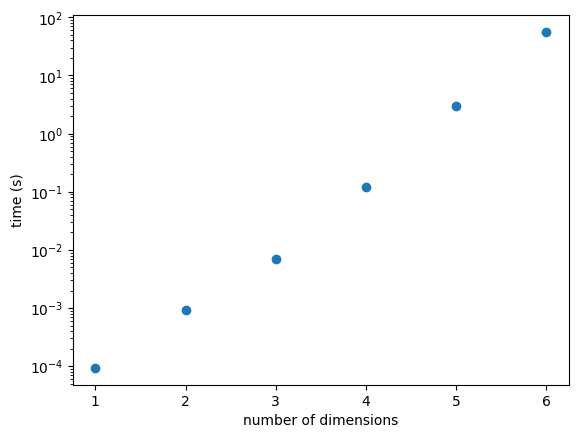

In [17]:
def measure_time(n):
    name = str(f"integrate.nquad((lambda *x_args: sum(x_args)), [(0, 1)]*{n})")
    return timeit.timeit(stmt=name, setup="from scipy import integrate", number=1)


def demo_multidim(n):
    x = np.arange(1, n + 1)
    y = np.zeros(n)

    for i in np.arange(1, n + 1):
        y[i - 1] = measure_time(i)

    plt.close("multidim")
    fig, ax = plt.subplots(num="multidim")
    ax.set_yscale("log")
    ax.plot(x, y, "o")
    ax.set_xlabel("number of dimensions")
    ax.set_ylabel("time (s)")
    ax.set_xticks(np.arange(1, n + 1))


demo_multidim(6)

The plot shows that the computational cost grows exponentially and becomes very high when the dimension is >=5.

## Numerical Differentiation

Let's touch upon differentiation now.
In contrast to integration, differentiation is an inherently sensitive problem, as small perturbations in the data can cause large changes in the result.

Generally, when approximating the derivative of a function whose values are known only at a discrete set of points, a good approach is to fit some smooth function to the given discrete data and then differentiate the approximating function to approximate the derivatives of the original function.

### Finite Difference Approximations

Although finite difference formulas are generally inappropriate for discrete or noisy data, they are very useful for approximating derivatives of a smooth function that is known analytically, or can be evaluated accurately for any given argument, or is defined implicitly by a differential equation.

The following equations will be useful for the next notebooks, where we'll deal with the numerical solution of differential equations.

We want to approximate the first and second derivatives of a smooth function $f:\mathbb{R}\rightarrow\mathbb{R}$ at a point $x$.

For a given step size $h$, we consider the Taylor series expansions

$$f(x+h)=f(x)+f'(x)h+\frac{f''(x)}{2}h^2+\frac{f'''(x)}{6}h^3+\cdots$$

and

$$f(x-h)=f(x)-f'(x)h+\frac{f''(x)}{2}h^2-\frac{f'''(x)}{6}h^3+\cdots$$

#### Approximations for the first derivative

- Solving the first series for $f'(x)$, we obtain the **forward difference formula**

    $$f'(x)=\frac{f(x+h)-f(x)}{h}-\frac{f''(x)}{2}h+\cdots\approx\frac{f(x+h)-f(x)}{h}$$

    This approximation is first-order accurate since the dominant remainder of the series is $\mathcal{O}(h)$.

- Similarly, we obtain the **backward difference formula** from the second series:

    $$f'(x)=\frac{f(x)-f(x-h)}{h}+\frac{f''(x)}{2}h+\cdots\approx\frac{f(x)-f(x-h)}{h}$$

- Adding both series together gives the **centered difference formula**

    $$f'(x)=\frac{f(x+h)-f(x-h)}{2h}-\frac{f'''(x)}{6}h^2+\cdots\approx\frac{f(x+h)-f(x-h)}{2h}$$

    which is second-order accurate.

#### Approximations for the second derivative

- Finally, subtracting the second series from the first gives a centered difference formula for the second derivative

    $$f''(x)=\frac{f(x+h)-2f(x)+f(x-h)}{h^2}-\frac{f^{(4)}(x)}{12}h^2+\cdots\approx\frac{f(x+h)-2f(x)+f(x-h)}{h^2}$$

    which is also second-order accurate.

By using function values at additional points, $x \pm 2h$, $x \pm 3h$,$\ldots$, we can derive similar finite difference approximations with still higher accuracy or for higher-order derivatives, although these come at a cost of more function evaluations.

## Richardson Extrapolation

In many problems, such as numerical integration or differentiation, we compute an approximate value for some quantity based on some step size. 
Ideally, we would like to obtain the limiting value as the step size goes to zero, but we cannot take the step size to be arbitrarily small because of excessive cost or rounding error.
Based on values for nonzero step sizes, however, we may be able to estimate what the value would be for a step size of zero. 
Note that the extrapolated value, is still only an approximation to the exact solution, and its accuracy is still limited by the step size and arithmetic precision used.

Let $F(h)$ denote the value obtained with step size $h$, using a method for which we know the scaling behavior as $h\rightarrow 0$ (i.e. the order of the method).

Starting from 

$$F(h)=a_0 +a_1h^p+\mathcal{O}(h^r)$$

as $h\rightarrow 0$ for some $p$ and $r$, with $r>p$.

We assume that we know the values of $p$ and $r$ from the method used to obtain $F(h)$, but not $a_0$ or $a_1$ (because $a_0=F(0)$ is the quantity we are trying to find in the first place!).

Suppose that we have computed $F$ for two step sizes, say, $h$ and $h/q$ for some positive integer $q$.
Then we have

$$F(h)=a_0 +a_1h^p+\mathcal{O}(h^r)$$

and

$$F(h/q)=a_0 +a_1(h/q)^p+\mathcal{O}(h^r)=a_0 +a_1q^{-p}h^p+\mathcal{O}(h^r)$$

This system of two linear equations in the two unknowns $a_0$ and $a_1$ is easily solved
to obtain

$$a_0=F(h)+\frac{F(h)-F(h/q)}{q^{-p}-1}+\mathcal{O}(h^r)$$

Thus, the accuracy of the improved value, $a_0$ , is $\mathcal{O}(h^r)$ rather than $\mathcal{O}(h^p)$.

If $F(h)$ is known for several values of $h$, then the extrapolation process can be repeated to produce still more accurate approximations, up to the limitations imposed by finite-precision arithmetic.

> **Example**
>
> To illustrate Richardson extrapolation, we use it to improve the accuracy of a finite difference approximation to the derivative of the function $\sin(x)$ at the point $x = 1$.
> Using the first-order accurate forward difference formula (FD), we have for this problem
>
> $$F(h)=a_0+a_1h+\mathcal{O}(h^2),$$
>
> which means that $p=1$ and $r=2$ in this case. 
Using step sizes of $h=0.5$ and $h/2=0.25$ (corresponding to $q=2$), we find
>
> $$\text{FD with stepsize h: }\frac{d\sin(x)}{dx}\approx\frac{\sin(x+h)-\sin(x)}{h}=\frac{\sin(1.5)-\sin(1)}{0.5}=0.312048=F(h)$$
>
> and
>
> $$\text{FD with stepsize h/2: }\frac{d\sin(x)}{dx}\approx\frac{\sin(x+h/2)-\sin(x)}{h/2}=\frac{\sin(1.25)-\sin(1)}{0.25}= 0.430055= F(h/2)$$
>
> The extrapolated value is then given by
>
> $$F(0)=a_0=F(h)+\frac{F(h)-F(h/2)}{(1/2)-1}=2F(h/2)-F(h)=0.548061$$
>
> For comparison, the real result is given by $\cos(1) \approx 0.540302$

### Romberg integration

Another example of Richardson extrapolation is **Romberg Integration**.

Similar to the estimate of the derivative of the function at a certain value in the previous example, our strategy to estimate the value of an integral is as follows
- Use a scheme (e.g. the composite trapezoid quadrature rule) to estimate our integral given a certain step size $h$
- Repeat this for a second step size (for example $h/2$)
- The two obtained values can be considered as two points $F(h)$ and $F(h/2)$ of the function $F$ whose behavior is determined by the scaling properties of the used integration scheme
- Calculate $F(0)$ to estimate what the value of our integral would be for an infinitely small $h$

> **Example**
>
> Consider the integral
>
> $$\int_0^{\pi/2}\sin(x)\,dx$$
>
> If we use the composite trapezoid quadrature rule, we get the following equation: (remember from the error analysis section that in the trapezoid rule the $\mathcal{O}(h^2)$ cancel out).
>
> $$F(h)=a_0+a_1h^2+\mathcal{O}(h^4)$$
>
> with $h=\pi/2$, we obtain the value $F(h)=0.785398$.
> 
> > This was obtained in the following way:
> >
> > The composite trapezoid rule is given by:
> >
> > $$\begin{split}T_k(f)=&\sum^k_{j=1}\frac{x_j-x_{j-1}}{2}(f(x_{j-1})+f(x_j))\\
=& h(\frac{1}{2}f(a)+f(x_1)+\cdots+f(x_{k-1}+\frac{1}{2}f(b))\end{split}$$
> >
> > For our specific function $\sin(x)$ with $h=\pi/2$ this becomes:
> >
> > $$F(\pi/2)=\frac{\pi}{2}\left(\frac{1}{2}\sin(0)+\frac{1}{2}\sin(\pi/2)\right)=0.785398$$
>
> Taking $q = 2$, we obtain the value $F(h/2) = F(\pi/4) = 0.948059$.
>
> > This was obtained in the following way:
> >
> > $$F(\pi/4)=\frac{\pi}{4}\left(\frac{1}{2}\sin(0)+\sin{(\pi/4)}+\frac{1}{2}\sin(\pi/2)\right)=0.948059$$
>
> The extrapolated value is then given by
>
> $$F(0)=a_0+\frac{F(h)-F(h/2)}{2^{-2}-1}=\frac{4F(h/2)-F(h)}{3}=1.002280$$
>
> which is substantially more accurate than either value previously computed (the exact answer is 1).
>

----

>
> For any integer $k \leq 0$, let $T_{k,0}$ denote the approximation to the integral $\int_a^b f(x) dx$
given by the composite trapezoid rule with step size $h_k = (b − a)/2^k$.
> Then for any integer $j$, $j = 1,\ldots, k$, we can recursively define the successive extrapolated values
> 
> $$T_{k,j} =\frac{4^jT_{k,j-1}-T_{k-1,j-1}}{4^j-1}$$
>
> which form a triangular array
>
> $$\begin{array}
{ccccc}
T_{0,0}&&&&\\
T_{1,0}&T_{1,1}&&&\\
T_{2,0}&T_{2,1}&T_{2,2}&&\\
T_{3,0}&T_{3,1}&T_{3,2}&T_{3,3}&\\
\vdots&\vdots&\vdots&\vdots&\ddots
\end{array}$$
>
> In this example we have already computed $T_{0,0} = 0.785398$, $T_{1,0} = 0.948059$, and the extrapolated value $ T_{1,1} = 1.002280$. 
> If we reduce the step size by another factor of two in the composite trapezoid rule, we obtain $T_{2,0} = F(h/4) = F(\pi/8)$ = 0.987116. 
>
> We can now combine the results for $h/2$ and $h/4$ to obtain the extrapolated value
>
> $$T_{2,1}= F(h/2)+ \frac{F(h/2)-F(h/4)}{2^{-2}-1}=\frac{4T_{2,0}-T_{1,0}}{4-1}=1.000135$$
>
> Because we have eliminated the leading $\mathcal{O}(h^2)$ error term for the composite trapezoid rule, the accuracy of the first level of extrapolated values is $\mathcal{O}(h^4)$. 
> Thus, we can further extrapolate on these values, but now with $p = 4$, to obtain
>
> $$T_{2,2}= \frac{4^2T_{2,1}-T_{1,1}}{4^2-1}=\frac{16 \times 1.000135-1.002280}{15}= 0.999992$$
>
> which is still more accurate than any of the values computed previously.
>

----

Recursive computation of extrapolated values in this manner, based on the composite trapezoid rule with successively halved step sizes, is called **Romberg integration**. 
It is capable of producing very high accuracy (up to the limit imposed by the arithmetic precision) for very smooth integrands. It is also implemented in [`scipy.integrate.romberg`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.integrate.romberg.html).

The same example can be solved with SciPy's `romb` function:

In [18]:
x = np.linspace(0, np.pi / 2, 33)
integrate.romb(np.sin(x), x[1] - x[0], show=True)

Richardson Extrapolation Table for Romberg Integration
 0.78540 
 0.94806  1.00228 
 0.98712  1.00013  0.99999 
 0.99679  1.00001  1.00000  1.00000 
 0.99920  1.00000  1.00000  1.00000  1.00000 
 0.99980  1.00000  1.00000  1.00000  1.00000  1.00000 


np.float64(1.0000000000000002)

## SciPy

Further information on all the functions implemented in scipy related to integration can be found here:
[scipy.integrate](https://docs.scipy.org/doc/scipy/tutorial/integrate.html)